<a href="https://colab.research.google.com/github/martinpius/RNN-ALIENS/blob/main/RNN_with_Complex_input_structure%2C_Masking_and_Padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on Google Colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...Please Load Your Drive...")
def time_fmt(x):
  h = int(x / (60 * 60))
  m = int(x % (60 * 60) / 60)
  s = int(x % 60)
  return f"{h}:{m:>03}: {s:>05.2f}"

display(time_fmt(123.43598))


Mounted at /content/drive/
You are on Google Colab with tensorflow version: 2.4.0


'0:002: 03.00'

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [3]:
#Sometimes we may need to pass a comple data structure to an LSTM cell. In this case we can 
#pass the nested data as list or dictionsry

In [4]:
#We design an LSTM nested cell from scratch using layers subclassing

In [5]:
class NestedCell(tf.keras.layers.Layer):
  def __init__(self, unit_1, unit_2, unit_3, **kwargs):
    self.unit_1 = unit_1
    self.unit_2 = unit_2 
    self.unit_3 = unit_3 
    self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
    self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
    super(NestedCell, self).__init__(**kwargs)
  
  def build(self, input_shapes):
    i1 = input_shapes[0][1]
    i2 = input_shapes[1][1]
    i3 = input_shapes[1][2]

    self.kernel_1 = self.add_weight(shape = (i1, self.unit_1),
                                    initializer = 'uniform',
                                    name = 'kernel_1')
    self.kernel_2_3 = self.add_weight(shape = (i2, i3, self.unit_2, self.unit_3),
                                      initializer = 'uniform',
                                      name = 'kernel_2_3')
  
  def call(self, inputs, states):
    input_1, input_2 = tf.nest.flatten(inputs)
    s1,s2 = states
    output_1 = tf.matmul(input_1, self.kernel_1)
    output_2_3 = tf.einsum('bij , ijkl->bkl', input_2, self.kernel_2_3)
    state_1 = s1 + output_1
    state_2_3 = s2 + output_2_3
    output = (output_1, output_2_3)
    new_state = (state_1, state_2_3)
    return output, new_state
  
  def get_config(self):
    return {'unit_1': self.unit_1, 'unit_2' : self.unit_2, 'unit_3' : self.unit_3}

In [6]:
#Instantiate the class

In [7]:
unit_1 = 10
unit_2 = 20
unit_3 = 30
i1 = 64
i2 = 32
i3 = 16
batch_size = 64
time_steps = 50
batch_num = 10
cell = NestedCell(unit_1, unit_2, unit_3)
rnn = tf.keras.layers.RNN(cell)
input_1 = tf.keras.Input(shape = (None, i1))
input_2 = tf.keras.Input(shape = (None, i2, i3))
outputs = rnn((input_1, input_2))

In [8]:
model = tf.keras.Model(inputs = [input_1, input_2], outputs = outputs)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 64)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 32, 16 0                                            
__________________________________________________________________________________________________
rnn (RNN)                       ((None, 10), (None,  307840      input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 307,840
Trainable params: 307,840
Non-trainable params: 0
__________________________________________________________________________________________________


In [10]:
#fake_data for the model

In [12]:
input_1 = np.random.random(size = (batch_size * batch_num, time_steps, i1))
input_2 = np.random.random(size = (batch_size * batch_num, time_steps, i2, i3))
out1 = np.random.random(size = (batch_size *batch_num, unit_1))
out2 = np.random.random(size = (batch_size * batch_num, unit_2, unit_3))
inputs = [input_1, input_2]
target = [out1, out2]


In [13]:
model.compile(loss = 'mse', metrics = ['accuracy'], optimizer = 'Adam')

In [14]:
model.fit(inputs, target, verbose = 2, epochs = 5, validation_split=0.10)

Epoch 1/5
18/18 - 3s - loss: 0.3918 - rnn_loss: 0.2087 - rnn_1_loss: 0.1830 - rnn_accuracy: 0.1007 - rnn_1_accuracy: 0.0329 - val_loss: 0.2325 - val_rnn_loss: 0.0970 - val_rnn_1_loss: 0.1356 - val_rnn_accuracy: 0.1250 - val_rnn_1_accuracy: 0.0352
Epoch 2/5
18/18 - 1s - loss: 0.2206 - rnn_loss: 0.0956 - rnn_1_loss: 0.1250 - rnn_accuracy: 0.0955 - rnn_1_accuracy: 0.0352 - val_loss: 0.2158 - val_rnn_loss: 0.0936 - val_rnn_1_loss: 0.1222 - val_rnn_accuracy: 0.1250 - val_rnn_1_accuracy: 0.0312
Epoch 3/5
18/18 - 0s - loss: 0.2062 - rnn_loss: 0.0919 - rnn_1_loss: 0.1143 - rnn_accuracy: 0.1042 - rnn_1_accuracy: 0.0393 - val_loss: 0.2085 - val_rnn_loss: 0.0900 - val_rnn_1_loss: 0.1185 - val_rnn_accuracy: 0.1406 - val_rnn_1_accuracy: 0.0383
Epoch 4/5
18/18 - 0s - loss: 0.1985 - rnn_loss: 0.0897 - rnn_1_loss: 0.1088 - rnn_accuracy: 0.0955 - rnn_1_accuracy: 0.0423 - val_loss: 0.2065 - val_rnn_loss: 0.0891 - val_rnn_1_loss: 0.1174 - val_rnn_accuracy: 0.1094 - val_rnn_1_accuracy: 0.0367
Epoch 5/5
18

In [15]:
#Padding and masking in sequence data
#Most of time we are required to padd the sequence data so as to retain uniformity
#of member's length. When we divide the sequence into batches it is crucial for the
#contigous batches to be of the same length. Therefore, padding is useful to guarantee that.

In [16]:
dfm = [
         ['hello', 'sam','how','are','you'],
         ['today','I','feel','super','fatigue'],
         ['probably','you','hsve','cold'],
         ['try','to','rest'],
         ['thanks','bye']
]

In [17]:
from tensorflow.keras.layers.experimental import preprocessing

In [18]:
#Lets create a ragged tensor for the above nested list

In [19]:
dfm = tf.ragged.constant(dfm)

In [20]:
#Obtaining the indices for each word in the nested list using stringlookup from layer's preprocessing method

In [21]:
layer = preprocessing.StringLookup()

In [22]:
layer.adapt(dfm)

In [23]:
data = layer(dfm)

In [24]:
data.to_list()

[[13, 8, 12, 18, 2], [4, 19, 14, 7, 15], [10, 2, 11, 16], [3, 5, 9], [6, 17]]

In [25]:
#Now we can pad the above data to create a tensor of suitable shape to train a given deep-learning model

In [26]:
padded_data = tf.keras.preprocessing.sequence.pad_sequences(data.to_list(), padding = 'post')

In [27]:
padded_data

array([[13,  8, 12, 18,  2],
       [ 4, 19, 14,  7, 15],
       [10,  2, 11, 16,  0],
       [ 3,  5,  9,  0,  0],
       [ 6, 17,  0,  0,  0]], dtype=int32)

In [28]:
#Since the padded data contain 0's which are actually of no information to the sequence we need to
#hide/mask them during training (This can be done using an embedding layer with mask_zero set to true)

In [29]:
my_embedding = tf.keras.layers.Embedding(input_dim = 100, output_dim = 20, mask_zero = True)

In [30]:
masked_data = my_embedding(padded_data)

In [31]:
masked_data.shape

TensorShape([5, 5, 20])

In [32]:
#We can obtain the mask as follow (This will be nested list of booleans with false inplace of zeros) 
#with same dimension as the padded data

In [33]:
print(masked_data._keras_mask)

tf.Tensor(
[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True False]
 [ True  True  True False False]
 [ True  True False False False]], shape=(5, 5), dtype=bool)


In [34]:
#We can propagate the mask to any layer which is capable of recognizing the mask down the network by passing it
#one time at the embedding layer

In [35]:
inputs = tf.keras.Input(shape = (10,),name = 'input_dim')
x = tf.keras.layers.Embedding(input_dim = 1000, 
                              output_dim = 64, 
                              mask_zero = True, 
                              name = 'embedding_with_a_mask')(inputs)
x = tf.keras.layers.LSTM(units = 128, 
                         return_sequences = True, 
                         dropout = 0.5,
                         recurrent_dropout = True,
                         kernel_initializer ='random_normal',
                         name = 'lstm_layer')(x)
x = tf.keras.layers.SimpleRNN(units = 64, 
                              return_sequences =True,
                              recurrent_dropout = True,
                              dropout = True,
                              kernel_initializer = 'random_normal',
                              name = 'rnn_layer')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu',
                          kernel_initializer = 'random_normal',
                          name = 'dense_layer')(x)
x = tf.keras.layers.Dropout(rate = 0.5, name = 'dropout')(x)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'output_layer')(x)

In [36]:
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'mask_rnn')

Model: "mask_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_dim (InputLayer)       [(None, 10)]              0         
_________________________________________________________________
embedding_with_a_mask (Embed (None, 10, 64)            64000     
_________________________________________________________________
lstm_layer (LSTM)            (None, 10, 128)           98816     
_________________________________________________________________
rnn_layer (SimpleRNN)        (None, 10, 64)            12352     
_________________________________________________________________
dense_layer (Dense)          (None, 10, 1024)          66560     
_________________________________________________________________
dropout (Dropout)            (None, 10, 1024)          0         
_________________________________________________________________
output_layer (Dense)         (None, 10, 10)            102

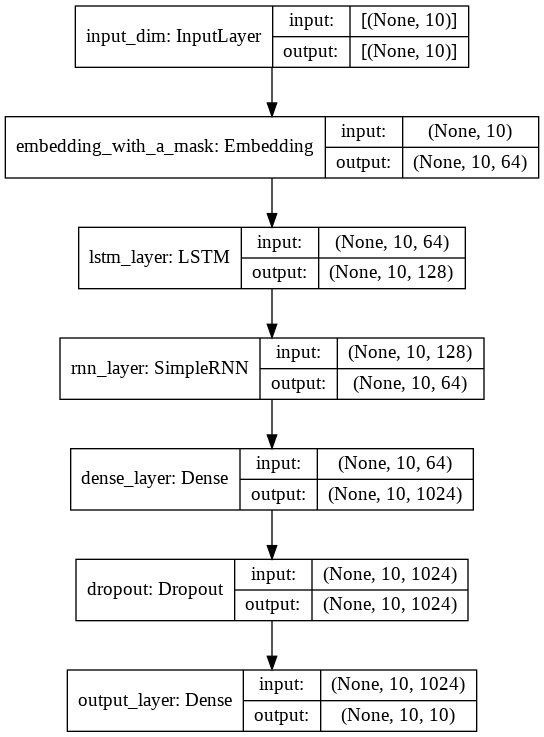

In [37]:
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'mask_rnn.png', show_shapes = True)

In [38]:
#A customized embedding layer with a custom mask
#We can build our customized embedding layer using layer-subclassing

In [39]:
class MyEmbedding(tf.keras.layers.Layer):
  def __init__(self, input_dim, output_dim, mask_zero = False, **kwargs):
    super(MyEmbedding, self).__init__(**kwargs)
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.mask_zero = mask_zero
  
  def build(self, inputs_shape):
    self.embeddings = self.add_weight(shape = (self.input_dim, self.output_dim),
                                     initializer = 'random_normal', dtype = 'float32',
                                     name = 'custom_embedding')
  def call(self, inputs):
    return tf.nn.embedding_lookup(self.embeddings, inputs)
  
  def compute_mask(self,inputs, mask = 0):
    if not self.mask_zero:
      return None
    return tf.not_equal(inputs, 0)

    


In [40]:
my_layer = MyEmbedding(100, 64,mask_zero = True)

In [41]:
#Create fake data
inputs = np.random.random(size = (5,5))*3
inputs = inputs.astype('int32')

In [42]:
out = my_layer(inputs)

In [43]:
out.shape

TensorShape([5, 5, 64])

In [44]:
#Check-out the mask

In [45]:
mask = my_layer.compute_mask(inputs)

In [46]:
print(mask)

tf.Tensor(
[[ True  True  True False  True]
 [ True False False  True  True]
 [ True False  True  True  True]
 [False  True False  True  True]
 [ True  True  True False False]], shape=(5, 5), dtype=bool)


In [47]:
#Apply the mask to the previous defined padded data (If we were required to build our desired mask)

In [48]:
new_masked_data = my_layer(padded_data)

In [49]:
new_masked_data

<tf.Tensor: shape=(5, 5, 64), dtype=float32, numpy=
array([[[ 0.01094729,  0.09964079,  0.01471988, ..., -0.0262303 ,
          0.06963911,  0.04919842],
        [-0.09880235,  0.01031647, -0.09170318, ..., -0.00450935,
         -0.10288034,  0.06527702],
        [-0.01592143,  0.00894991, -0.06765077, ...,  0.03644257,
         -0.01307665, -0.00957612],
        [-0.07119333,  0.03027589,  0.07105527, ..., -0.08369299,
         -0.03695545, -0.03244263],
        [ 0.04965132,  0.01134808,  0.01197459, ..., -0.05369861,
         -0.05813081,  0.02533634]],

       [[-0.02984283,  0.00584389, -0.06950971, ..., -0.0139525 ,
          0.03860159,  0.12958501],
        [-0.04393492, -0.02792515, -0.02605267, ...,  0.00192289,
          0.04882456, -0.015621  ],
        [ 0.05900771,  0.01707638, -0.08333511, ..., -0.09567377,
          0.01565579,  0.01776707],
        [ 0.0027602 , -0.01823752,  0.03233507, ...,  0.00375259,
          0.0011599 , -0.05122598],
        [ 0.05154755, -0.021

In [50]:
#Callback subclassing:
#We can customized methods in callbacks according to our needs.
#Callbacks is applicable during training, eveluation and predictions/inference
#Some important methods in callbacks include TensorBord for vizualization and ModelCheckpoint for periodically saving the model

In [51]:
#Callbacks has varios methods which we can overide by subclassing keras.callbacks.Callback...
#Global methods include on_train/test/predict_begin(self, logs = None)
#Global methods on_train/test/predict_end(self, logs = None)
#Batch methodsn on _train/test/predict_batch_begin(self, logs = None)-end
#Epoch method on train only--on_epoch_begin(self, epoch,logs = None) - end

In [52]:
#An example on callback customization on simple resnet for cifar10 data


In [53]:
def model_creator():
  inputs = tf.keras.Input(shape = (32,32,3), name = 'cifar10_img')
  x = tf.keras.layers.Conv2D(filters = 128, 
                             kernel_size = (3,3), 
                             padding = 'same', 
                             activation = 'relu',
                             kernel_initializer = 'random_normal',
                             strides = (2,2),name = 'Conv_1')(inputs)
  x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3,3),
                           activation = 'relu',
                           kernel_initializer ='random_normal',
                           strides = (2,2),
                           padding = 'same',
                           name = 'conv_2')(x)
  out = tf.keras.layers.GlobalMaxPooling2D(name = 'global_max_pooling')(x)

  x = tf.keras.layers.Conv2D(filters = 128,
                           kernel_size = (3,3),
                           activation = 'relu',
                           padding = 'same',
                           strides = (2,2),
                           kernel_initializer = 'random_normal',
                           name = 'conv_3')(x)
  x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3,3),
                           activation = 'relu',
                           padding = 'same',
                           kernel_initializer = 'random_normal',
                           strides = (2,2),
                           name = 'conv_4')(x)
  block_1 = tf.keras.layers.add([out, x], name = 'block_1')

  x = tf.keras.layers.Conv2D(filters = 128,
                           kernel_size = (3,3),
                           activation = 'relu',
                           strides = (2,2),
                           padding = 'same',
                           kernel_initializer = 'random_normal',
                           name = 'conv_5')(block_1)
  x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3,3),
                           activation = 'relu',
                           padding = 'same',
                           strides = (2,2),
                           kernel_initializer = 'random_normal',
                           name = 'conv_6')(x)
  block_2 = tf.keras.layers.add([block_1, x], name = 'block_2')

  x = tf.keras.layers.Conv2D(filters = 128,
                           kernel_size = (3,3),
                           activation = 'relu',
                           kernel_initializer = 'random_normal',
                           strides = (2,2),
                           padding = 'same',
                           name = 'conv_7')(block_2)
  x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3,3),
                           strides = (2,2),
                           padding = 'same',
                           activation = 'relu',
                           kernel_initializer = 'random_normal',
                           name = 'conv_8')(x)
  block_3 = tf.keras.layers.add([block_2, x], name = 'block_3')

  x = tf.keras.layers.Conv2D(filters = 128,
                           kernel_size = (3,3),
                           kernel_initializer = 'random_normal',
                           activation = 'relu',
                           strides = (2,2),
                           padding = 'same',
                           name = 'conv_9')(block_3)
  x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3,3),
                           strides = (2,2),
                           kernel_initializer = 'random_normal',
                           activation = 'relu',
                           padding = 'same',
                           name = 'conv_10')(x)
  x = tf.keras.layers.BatchNormalization(name = 'batch_norm')(x)
  x = tf.keras.layers.Flatten(name = 'flatten')(x)
  x = tf.keras.layers.Dense(units = 1024, activation = 'relu', kernel_initializer = 'random_normal')(x)
  x = tf.keras.layers.Dropout(rate = 0.5, name = 'dropout')(x)
  outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'outputs')(x)

  model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'simple_resnet')
  model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'RMSprop')
  return model



In [54]:
model = model_creator()

Model: "simple_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar10_img (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 16, 16, 128)  3584        cifar10_img[0][0]                
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 8, 8, 64)     73792       Conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 4, 4, 128)    73856       conv_2[0][0]                     
______________________________________________________________________________________

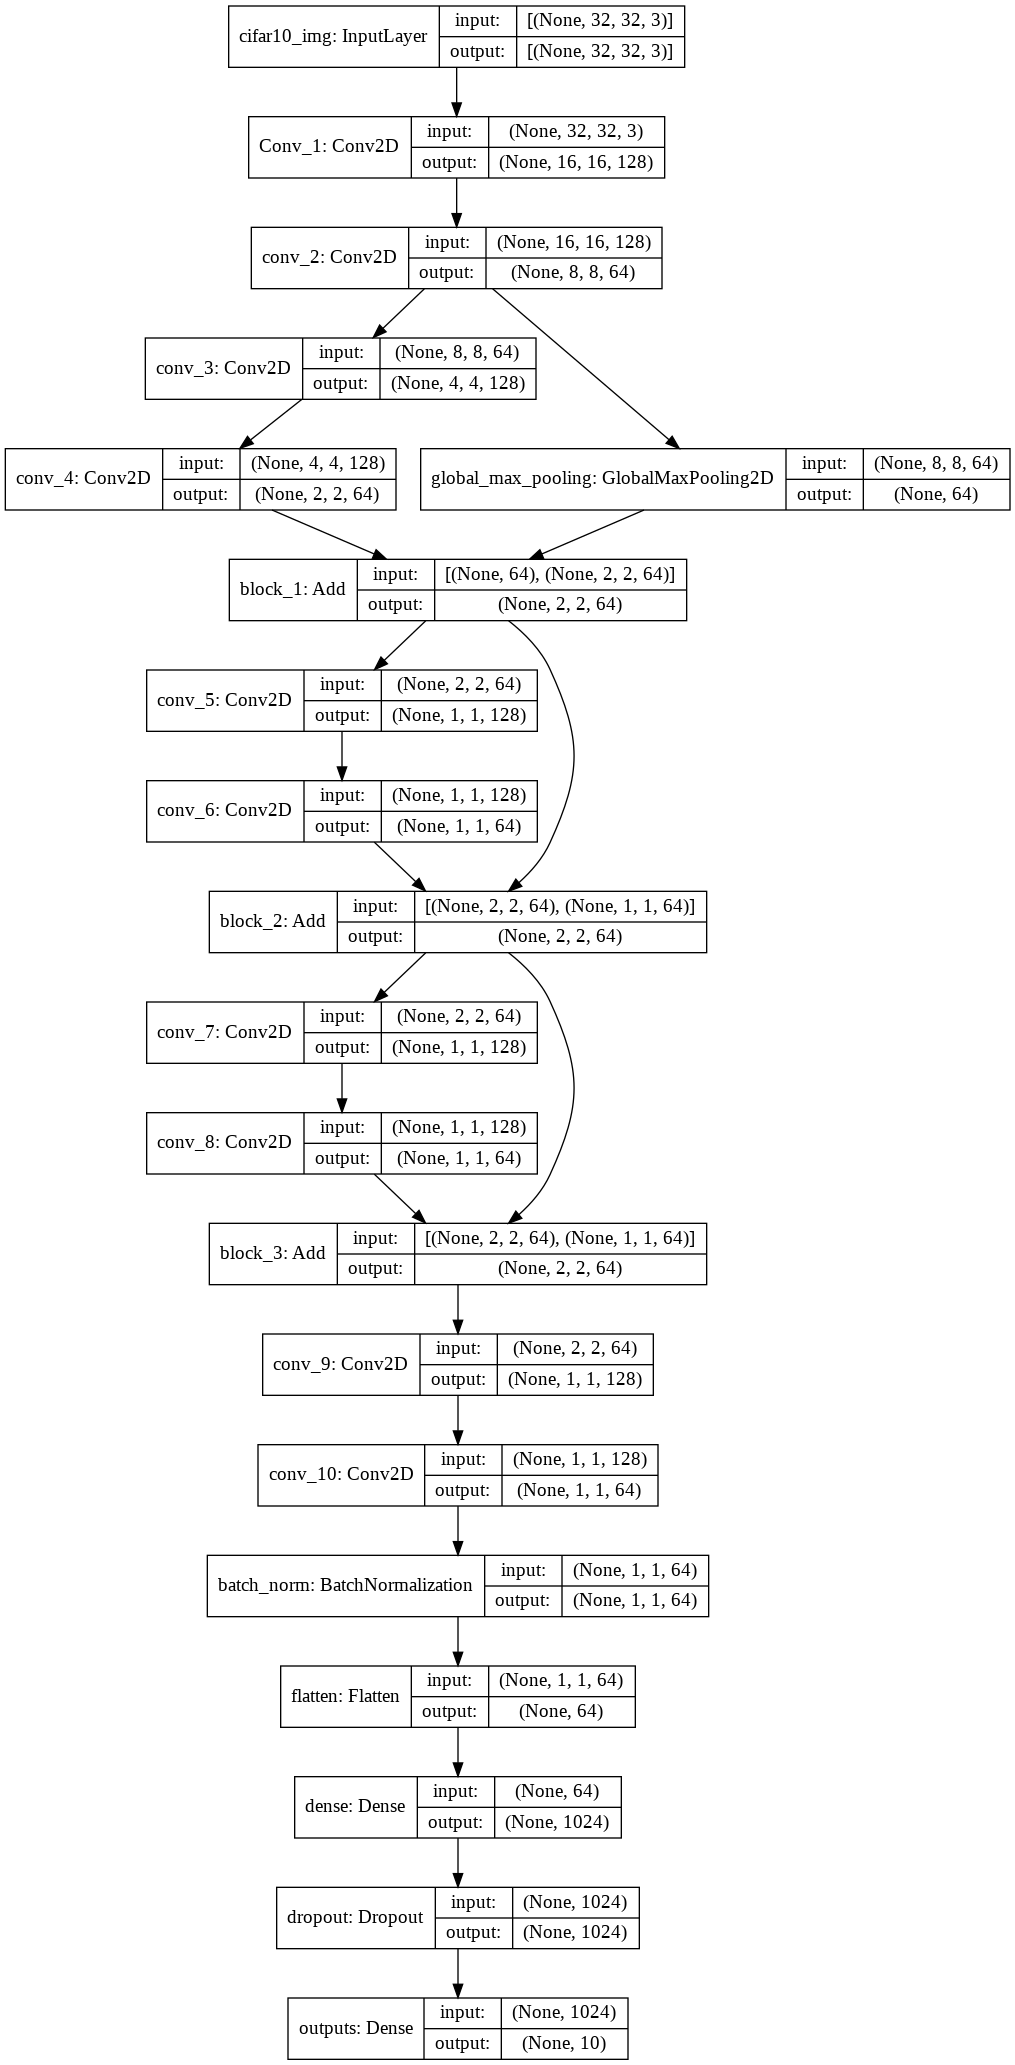

In [55]:
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'resnet.png', show_shapes = True)

In [56]:
#We can train this model on cifar10 dataset using a customized callback as follow:
#We first load the data
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [57]:
#Preprocess the data

In [58]:
x_train, x_test = x_train.astype('float32')/255.0, x_test.astype('float32')/255.0

In [59]:
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [60]:
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

x_train_shape: (50000, 32, 32, 3), y_train_shape: (50000, 10)
x_test_shape: (10000, 32, 32, 3), y_test_shape: (10000, 10)


In [61]:
#Use the callbacks subclassing to print out the logs keys at every train/test/predict steps
class CustomCallbacks(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs = None):
    keys = list(logs.keys())
    print(f"begining training, got logs keys: {keys}")
  
  def on_train_end(self, logs = None):
    keys = list(logs.keys())
    print(f"end training, got logs keys :{keys}")
  
  def on_epoch_begin(self, epoch, logs = None):
    keys = list(logs.keys())
    print(f"begin of epoch: {epoch} of training with logs keys: {keys}")
  
  def on_epoch_end(self, epoch, logs = None):
    keys = list(logs.keys())
    print(f"end of epoch: {epoch} of training with log keys: {keys}")
  
  def on_test_begin(self, logs = None):
    keys = list(logs.keys())
    print(f"begin of testing with logs keys: {keys}")
  
  def on_test_end(self, logs = None):
    keys = list(logs.keys())
    print(f"end of testing with logs keys: {keys}")
  def on_predict_begin(self, logs = None):
    keys = list(logs.keys())
    print(f"begin of prediction has logs keys: {keys}")
  
  def on_predict_end(self, logs = None):
    keys = list(logs.keys())
    print(f"end of prediction has logs keys: {keys}")
  def on_train_batch_begin(self, batch, logs = None):
    keys = list(logs.keys())
    print(f"begining of training of batch: {batch}, has logs keys: {keys}")
  
  def on_train_batch_end(self, batch, logs = None):
    keys = list(logs.keys())
    print(f"end of training of batch: {batch} has logs keys: {keys}")
  
  def on_test_batch_begin(self, batch, logs = None):
    keys = list(logs.keys())
    print(f"begining of test of batch: {batch} has logs keys: {keys}")
  
  def on_test_batch_end(self, batch, logs):
    keys = list(logs.keys())
    print(f"end of test of batch: {batch} has got logs keys: {keys}")
  
  def on_predict_batch_begin(self, batch, logs = None):
    keys = list(logs.keys())
    print(f"begin of prediction of batch: {batch} has got logs keys: {keys}")
  
  def on_predict_batch_end(self, batch, logs = None):
    keys = list(logs.keys())
    print(f"end of prediction of batch {batch} has got logs keys {keys}")
  


In [65]:
#train the model without the customized callbacks (No logs information will show)
import time
tic = time.time()
model = model_creator()
model.fit(x_train, y_train, validation_split = 0.20, verbose = 2, batch_size = 64, epochs = 2)
model.evaluate(x_test, y_test, batch_size = 64, verbose = 2)
toc = time.time()

print(f"time elapsed: {time_fmt(toc - tic)}")

Epoch 1/2
625/625 - 5s - loss: 1.5677 - accuracy: 0.4195 - val_loss: 2.3648 - val_accuracy: 0.3206
Epoch 2/2
625/625 - 4s - loss: 1.2327 - accuracy: 0.5561 - val_loss: 2.1888 - val_accuracy: 0.3947
157/157 - 0s - loss: 2.1934 - accuracy: 0.3875
time elapsed: 0:000: 10.00


In [98]:
model = model_creator()
model.fit(x_train, y_train, validation_split = 0.2, batch_size = 64, verbose = 2, epochs = 2, callbacks = [CustomCallbacks()])

begining training, got logs keys: []
Epoch 1/2
begin of epoch: 0 of training with logs keys: []
begining of training of batch: 0, has logs keys: []
end of training of batch: 0 has logs keys: ['loss', 'accuracy']
begining of training of batch: 1, has logs keys: []
end of training of batch: 1 has logs keys: ['loss', 'accuracy']
begining of training of batch: 2, has logs keys: []
end of training of batch: 2 has logs keys: ['loss', 'accuracy']
begining of training of batch: 3, has logs keys: []
end of training of batch: 3 has logs keys: ['loss', 'accuracy']
begining of training of batch: 4, has logs keys: []
end of training of batch: 4 has logs keys: ['loss', 'accuracy']
begining of training of batch: 5, has logs keys: []
end of training of batch: 5 has logs keys: ['loss', 'accuracy']
begining of training of batch: 6, has logs keys: []
end of training of batch: 6 has logs keys: ['loss', 'accuracy']
begining of training of batch: 7, has logs keys: []
end of training of batch: 7 has logs key